# Notebook for Home Credit dataset
Author: Johannes Pastorek, johannes.pastorek@gmail.com

In [293]:
reset -fs

In [334]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt#

from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

%matplotlib inline
plt.style.use('seaborn')
np.random.seed(42)

In [ ]:
def isNaN(num):
    return num != num


def get_col_descr(feature):
    return column_description[column_description.row == feature].loc[:, 'description'].tolist()


def transform_days_feats(cols):
    for col in cols:
        if col in list(X.columns):
            new_col_name = col.split('_')[-1]
            X[new_col_name] = X[col].apply(lambda x: int(x / -365))
            X.drop([col], axis=1, inplace=True)
            print(col + '  =>  ' + new_col_name)
         
        
def remove_nan_cols(cols):
    new_cols = list()
    for col in cols:
        if X[col].isna().sum() == 0:
            new_cols.append(col)
        else:
            X.drop([col], axis=1, inplace=True)
            print('removed column: ' + col)
    return new_cols


def hist_print(data1, data0, header, xlab, bin_count):
    plt.hist(data1, alpha=0.4, label='"bad" loan', bins=bin_count, weights=np.ones(len(data1)) / len(data1))
    plt.hist(data0, alpha=0.4, label='other', bins=bin_count, weights=np.ones(len(data0)) / len(data0))
    plt.grid(b=None)
    plt.title(header)
    plt.xlabel(xlab)
    plt.ylabel('Frequency')
    plt.legend(loc='best')
    plt.show()

# Data

In [295]:
# import train data
train = pd.read_csv('application_train.csv')
# import test data
test = pd.read_csv('application_test.csv')
# add col for differentiating between train and test
train['dataset'], test['dataset'] = 0, 1
# create one combined data set X
X = pd.concat([train,test],sort=True)
# make column names lower case
X.columns = X.columns.str.lower()

In [325]:
c = pd.read_csv('HomeCredit_columns_description.csv', encoding= 'unicode_escape')
cd = c[c.Table == 'application_{train|test}.csv']
cd['Row'] = cd['Row'].apply(lambda x: x.lower())
cd = cd[['Row', 'Description']]
cd = cd.rename({'Row':'Variable', 'Definition':'Definition'})
cd = cd.set_index('Row')
cd.head()

/Users/johannespastorek/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Description
Row,
sk_id_curr,ID of loan in our sample
target,Target variable (1 - client with payment diffi...
name_contract_type,Identification if loan is cash or revolving
code_gender,Gender of the client
flag_own_car,Flag if the client owns a car


In [331]:
description = cd.loc['target']
description.tolist()

['Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)']

# Cleaning

In [332]:
# shape of train and test data
print(train.shape)
print(test.shape)

(307511, 123)
(48744, 122)


## Transform Time Features

In [ ]:
days_cols = [x for x in list(X.columns) if (x.split('_')[0] == 'days')]
days_cols = remove_nan_cols(days_cols)

In [ ]:
transform_days_feats(days_cols)

In [ ]:
# employed -1000 replace with NaN
X['employed'] = X.employed.apply(lambda x: float('NaN') if x == -1000 else x)

## Categorical and Numerical Features

In [297]:
# differentiate between num (no object type) and cat (object type) features
cat_features = list(X.columns[X.dtypes==object])
num_features = list(X.columns[X.dtypes!=object])

In [298]:
# how many unique entries does each cat feature have
X[cat_features].describe().loc['unique',:]

code_gender                    3
emergencystate_mode            2
flag_own_car                   2
flag_own_realty                2
fondkapremont_mode             4
housetype_mode                 3
name_contract_type             2
name_education_type            5
name_family_status             6
name_housing_type              6
name_income_type               8
name_type_suite                7
occupation_type               18
organization_type             58
wallsmaterial_mode             7
weekday_appr_process_start     7
Name: unique, dtype: object

In [299]:
# how many missings do cat features have
X[cat_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 48743
Data columns (total 16 columns):
code_gender                   356255 non-null object
emergencystate_mode           188291 non-null object
flag_own_car                  356255 non-null object
flag_own_realty               356255 non-null object
fondkapremont_mode            113163 non-null object
housetype_mode                178339 non-null object
name_contract_type            356255 non-null object
name_education_type           356255 non-null object
name_family_status            356255 non-null object
name_housing_type             356255 non-null object
name_income_type              356255 non-null object
name_type_suite               354052 non-null object
occupation_type               244259 non-null object
organization_type             356255 non-null object
wallsmaterial_mode            176021 non-null object
weekday_appr_process_start    356255 non-null object
dtypes: object(16)
memory usage: 46.2+ MB


In [300]:
# how many missings do num features have
X[num_features].info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 48743
Data columns (total 107 columns):
amt_annuity                     356219 non-null float64
amt_credit                      356255 non-null float64
amt_goods_price                 355977 non-null float64
amt_income_total                356255 non-null float64
amt_req_credit_bureau_day       308687 non-null float64
amt_req_credit_bureau_hour      308687 non-null float64
amt_req_credit_bureau_mon       308687 non-null float64
amt_req_credit_bureau_qrt       308687 non-null float64
amt_req_credit_bureau_week      308687 non-null float64
amt_req_credit_bureau_year      308687 non-null float64
apartments_avg                  176307 non-null float64
apartments_medi                 176307 non-null float64
apartments_mode                 176307 non-null float64
basementarea_avg                148671 non-null float64
basementarea_medi               148671 non-null float64
basementarea_mode               148671 non-null f

# Exploration

## Features Importance with XGBoost

In [301]:
def get_feature_importance(data, no_of_features, cats=cat_features):
    # replace cat NaNs with 'missing'
    data[cat_features] = data[cat_features].fillna('missing')
    # turn cat features into numbers
    for col in data[cat_features]:
        data[col] = pd.factorize(X[col])[0]
    
    # fit XGB classifier to train data
    model = XGBClassifier()
    X_train = data[data.dataset == 0].drop(columns=['target', 'dataset'])
    y_train = data[data.dataset == 0].target
    model.fit(X_train, y_train)
    
    # zip column names with their respective feature importances
    fi = list(zip(list(X_train), model.feature_importances_))
    # sort by feature importance
    fi.sort(key=lambda x: x[1])
    
    # take x best features
    feature_list = list(zip(*fi[-no_of_features:]))
    # create plot
    plt.figure(figsize=(12, 5))
    plt.grid(b=None)
    plt.title('Feature Importance')
    plt.barh(range(len(feature_list[1])), feature_list[1])
    my_yticks = feature_list[0]
    plt.yticks(list(range(len(my_yticks))), my_yticks)
    plt.xlabel('Feature Score')
    plt.show()
    
    return my_yticks

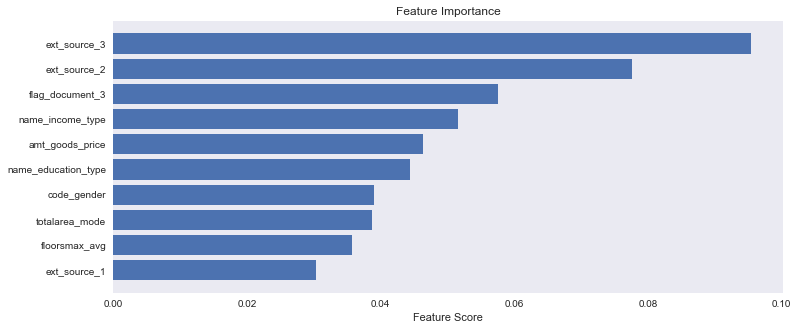

In [302]:
features = get_feature_importance(X.copy(), 10)

# Feature Engineering

In [303]:
# only use top x features
X = X[list(features) + ['target', 'dataset']]
# differentiate between num (no object type) and cat (object type) features
cat_features = list(X.columns[X.dtypes==object])
num_features = list(X.columns[X.dtypes!=object])

In [304]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 48743
Data columns (total 12 columns):
ext_source_1           162345 non-null float64
floorsmax_avg          179914 non-null float64
totalarea_mode         185200 non-null float64
code_gender            356255 non-null object
name_education_type    356255 non-null object
amt_goods_price        355977 non-null float64
name_income_type       356255 non-null object
flag_document_3        356255 non-null int64
ext_source_2           355587 non-null float64
ext_source_3           286622 non-null float64
target                 307511 non-null float64
dataset                356255 non-null int64
dtypes: float64(7), int64(2), object(3)
memory usage: 35.3+ MB


In [305]:
X.columns

Index(['ext_source_1', 'floorsmax_avg', 'totalarea_mode', 'code_gender',
       'name_education_type', 'amt_goods_price', 'name_income_type',
       'flag_document_3', 'ext_source_2', 'ext_source_3', 'target', 'dataset'],
      dtype='object')

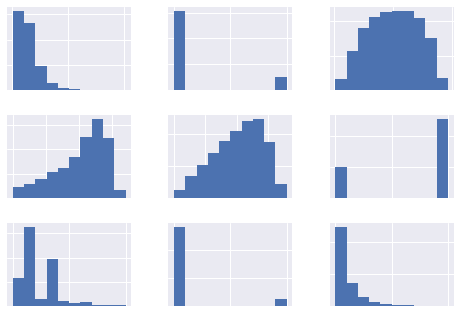

In [306]:
ax = X.hist()
# disable axis labels
for axis in ax.flatten():
    axis.set_title('')
    axis.set_xticklabels([]) 
    axis.set_yticklabels([])
plt.show()

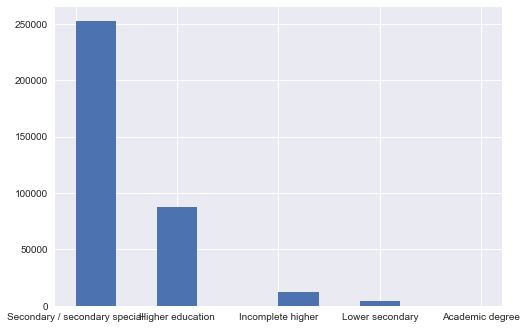

In [307]:
X['name_education_type'].hist()

In [308]:
X['higher_educ'] = X['name_education_type'].apply(lambda x: 
                                                  1 if (x == 'Higher education') | 
                                                       (x == 'Academic degree')  
                                                  else 0
                                                 )
X = X.drop('name_education_type', axis=1)

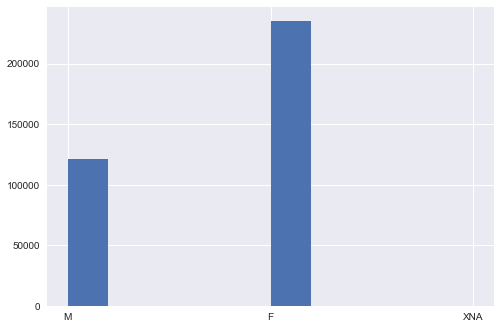

In [309]:
X['code_gender'].hist()

In [310]:
X['code_gender'] = X['code_gender'].replace('XNA', np.NaN)

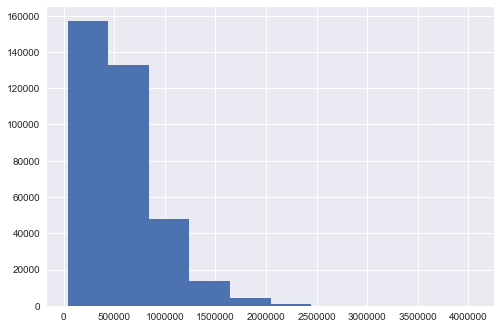

In [311]:
X['amt_goods_price'].hist()

In [312]:
X['amt_goods_price_log'] = X['amt_goods_price'].apply(lambda x: np.log(x+1))
X = X.drop('amt_goods_price', axis=1)

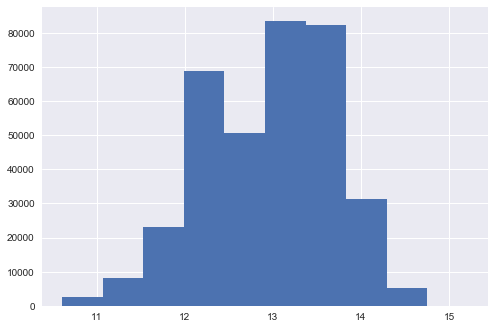

In [313]:
X['amt_goods_price_log'].hist()

In [314]:
X['name_income_type'].unique()

array(['Working', 'State servant', 'Commercial associate', 'Pensioner',
       'Unemployed', 'Student', 'Businessman', 'Maternity leave'],
      dtype=object)

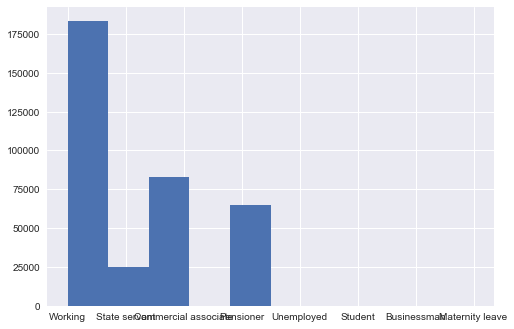

In [315]:
X['name_income_type'].hist()

In [316]:
X.groupby('name_income_type').count()['target']

name_income_type
Businessman                 10
Commercial associate     71617
Maternity leave              5
Pensioner                55362
State servant            21703
Student                     18
Unemployed                  22
Working                 158774
Name: target, dtype: int64

In [317]:
((X.groupby('name_income_type').sum()['target'] / X.groupby('name_income_type').count()['target']) * 100)

name_income_type
Businessman              0.000000
Commercial associate     7.484257
Maternity leave         40.000000
Pensioner                5.386366
State servant            5.754965
Student                  0.000000
Unemployed              36.363636
Working                  9.588472
Name: target, dtype: float64

In [318]:
X = X.drop('name_income_type', axis=1)

In [319]:
X.columns

Index(['ext_source_1', 'floorsmax_avg', 'totalarea_mode', 'code_gender',
       'flag_document_3', 'ext_source_2', 'ext_source_3', 'target', 'dataset',
       'higher_educ', 'amt_goods_price_log'],
      dtype='object')

## Add own Features

In [ ]:
modes = list()
for col in list(X.columns):
    if col.split('_')[-1] == 'mode':
        modes.append(col)

mode_df = X[modes]
        
X['mode_nans'] = mode_df.isna().sum(axis=1) == 0
X['mode_nans'] = X['mode_nans'].astype(int)

In [ ]:
X['higher_educ'] = X['name_education_type'].apply(lambda x: 
                                                  1 if (x == 'Higher education') | 
                                                       (x == 'Academic degree')  
                                                  else 0
                                                 )

In [ ]:
X['term'] = X.amt_annuity / X.amt_credit
X['income_credit'] = X.amt_credit / X.amt_income_total

# Predictive Modeling

## Cost-Sensitive Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=2000, class_weight='balanced')
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=5)

print('Mean ROC AUC: %.3f' % np.mean(scores))

## Random Forest with SMOTE

In [ ]:
model = RandomForestClassifier()
resample = SMOTEENN()
pipeline = Pipeline(steps=[('r', resample), ('m', model)])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=5)

print('Mean ROC AUC: %.3f' % np.mean(scores))

## XGBoost

In [ ]:
model = XGBClassifier(learning_rate =0.1,
                      n_estimators=500,
                      max_depth=5,
                      min_child_weight=1,
                      gamma=0,
                      subsample=0.8,
                      colsample_bytree=0.8,
                      objective= 'binary:logistic',
                      nthread=4,
                      scale_pos_weight=1,
                      seed=1
)

model.fit(X_train, y_train)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=5)
print('Mean ROC AUC: %.3f' % np.mean(scores))

## Hyperparameter Tuning

# Visualization

In [ ]:
plt1 = X[(X.dataset == 0) & (X.target == 1)].gender
plt0 = X[(X.dataset == 0) & (X.target == 0)].gender
hist_print(plt1, plt0, "3rd External Source", 'external source 3', 15)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

recipe = ['"bad" loans', 'all other cases']

data = [8, 92]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title('Distribution of "bad" loans')
plt.savefig('targetDistr.png')
plt.show()